# Titanic Survival Prediction

This is a short lesson on data cleaning and classification prediction, using Kaggle's 
introductory competition, [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic).


In [768]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
import re

In [769]:
def read_csv(filename):
    data = []
    with open(filename) as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    
    return data

def safe_cast_numeric(val, dtype, default=-1):
    try:
        return dtype(val)
    except (ValueError, TypeError):
        return default

In [770]:
train = read_csv("data/train.csv")
test = read_csv("data/test.csv")

cols = train[0]
rows = train[1:]

t_cols = test[0]
t_rows = test[1:]

train_df = pd.DataFrame(rows, columns=cols)
test_df = pd.DataFrame(t_rows, columns=t_cols)

In [771]:
def col_as_numeric(df_col, dtype, default_value=None):
    tmp = df_col.apply(lambda x: safe_cast_numeric(x, dtype, -1))
    
    if default_value is not None:
        tmp[tmp == -1] = dtype(default_value)
    else:
        tmp[tmp == -1] = tmp[tmp != -1].mean()

    return tmp

def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

def categorize_titles(df):
    df['Title'] = df['Name'].apply(get_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].fillna('Rare')
    return df

def map_col_to_ids(df, col_name, col_id_name):
    temp_df = pd.DataFrame({col_name: df[col_name].unique(), 
                            col_id_name:range(len(df[col_name].unique()))})
    df = df.merge(temp_df, on=col_name, how='left')
    return df

def explode_col(df, col):
    values = df[col].unique()
    for val in values:
        df[col+"_"+str(val)] = df[col].apply(lambda x: 1 if x == val else 0)
    return df

def clean(df):    
    # Survived
    if 'Survived' in df.columns:
        df['Survived'] = df['Survived'].astype(int)
    
    # Age
    df['Age'] = col_as_numeric(df['Age'], float)
    
    # Age bins
    bin_cuts = [0, 11, 23, 34, 45, 57, 68, 100]
    df['Age_bin'] = pd.cut(df['Age'], bin_cuts).apply(lambda x: str(x))
    actual_bins = df['Age_bin'].unique()
    for age_bin in actual_bins[:-1]:
        if age_bin == np.nan:
            continue
        df[age_bin] = df['Age_bin'].apply(lambda x: 1 if x == age_bin else 0)
    _ = df.pop('Age')
    _ = df.pop('Age_bin')

    # Sex
    df = map_col_to_ids(df, 'Sex', 'Sex_id')
    df = explode_col(df, 'Sex_id')
    _ = df.pop('Sex')
    _ = df.pop('Sex_id')
    
    
    # SibSp - # of siblings / spouses aboard 
    df['SibSp'] = col_as_numeric(df['SibSp'], int, 0)
    
    # Parch - # of parents / children aboard
    df['Parch'] = col_as_numeric(df['Parch'], int, 0)
    
    # Total relatives
    df['Relatives'] = df['SibSp'] + df['Parch']
    
    # Is alone
    df['IsAlone'] = df['Relatives'].apply(lambda x: 1 if x == 0 else 0)
    
    df = map_col_to_ids(df, 'Relatives', 'Relatives_id')
    df = explode_col(df, 'Relatives_id')
    _ = df.pop('Relatives')
    _ = df.pop('Relatives_id')
    
    # Names and titles
    df = categorize_titles(df)
    df = map_col_to_ids(df, 'Title', 'Title_id')
    df = explode_col(df, 'Title_id')
    _ = df.pop('Title')
    _ = df.pop('Title_id')
    
    # # Fare
    df['Fare'] = col_as_numeric(df['Fare'], float)
    bin_cuts = [0, 15, 25, 35, 45, 60, 200, 600]
    df['Fare_bin'] = pd.cut(df['Fare'], bin_cuts).apply(lambda x: str(x))
    df = map_col_to_ids(df, 'Fare_bin', 'Fare_id')
    df = explode_col(df, 'Fare_id')
    _ = df.pop('Fare')
    _ = df.pop('Fare_bin')
    _ = df.pop('Fare_id')
     
    # Pclass
    df['Pclass'] = col_as_numeric(df['Pclass'], int)
    df = map_col_to_ids(df, 'Pclass', "Pclass_id")
    df = explode_col(df, 'Pclass_id')
    _ = df.pop('Pclass')
    _ = df.pop('Pclass_id')
    
    # Cabin - by letter class
    df['CabinClass'] = df['Cabin'].apply(lambda x: x if len(x) == 0 else x[0])
    df = map_col_to_ids(df, 'CabinClass', "CabinClass_id")
    df = explode_col(df, 'CabinClass_id')
    _ = df.pop('CabinClass')
    _ = df.pop('CabinClass_id')
    
    # Embarked
    df = map_col_to_ids(df, 'Embarked', "Embarked_id")
    df = explode_col(df, 'Embarked_id')
    _ = df.pop('Embarked')
    _ = df.pop('Embarked_id')
        
    return df

df = clean(train_df)
t_df = clean(test_df)

In [772]:
for col in df.columns:
    if col not in t_df.columns:
        t_df[col] = 0

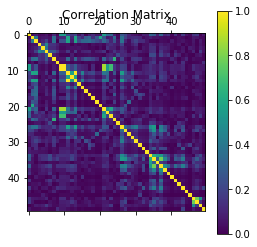

In [773]:
# Check correspondences to find any over 0.5 with survival 
corr = df.corr().abs()

plt.matshow(df.corr().abs())
cb = plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

In [774]:
num_cols = df.select_dtypes('number').columns
df_numeric = df[num_cols]
df_numeric = df_numeric.dropna()
survived = df_numeric.pop('Survived')

X = df_numeric.to_numpy()
y = survived.to_numpy()

test_p = 0.9
t = int(test_p * len(y))
X_test = X[:t]
X_train = X[t:]
y_test = y[:t]
y_train = y[t:]

t_num_cols = t_df.select_dtypes('number').columns
t_df_numeric = t_df[t_num_cols]
t_df_numeric = t_df_numeric.dropna()
t_survived = t_df_numeric.pop('Survived')

X_final = t_df_numeric.to_numpy()

In [775]:
clf = svm.SVC(gamma='scale', kernel='linear', random_state=0, decision_function_shape='ovo')

In [776]:
lin_clf = svm.LinearSVC(random_state=0)

In [777]:
ada_clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10, random_state=0), 
                             n_estimators=100, random_state=0)

In [778]:
gr_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)

In [779]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [780]:
erf_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [781]:
eclf = VotingClassifier(estimators=[('Vanilla SVC', clf),
                                    ('Linear SVC', lin_clf),
                                    ('AdaBoost, random forest', ada_clf), 
                                    ('Gradient Boosting, random forest', gr_clf),
                                    ('Random Forest', rf_clf),
                                    ('Extra Trees', erf_clf),
                                    ], voting='hard')
for clft in eclf.estimators:
    print("\n"+clft[0])
    clf = clft[1]
    clf.fit(X_train, y_train)
    print("- train: {}\n- test: {}".format(clf.score(X_train, y_train), 
                                           clf.score(X_test, y_test)))
eclf.fit(X_train, y_train)
print("\n====\nVoting Classifier:\n- train: {}\n- test: {}".format(eclf.score(X_train, y_train), 
                                                           eclf.score(X_test, y_test)))


Vanilla SVC
- train: 0.9333333333333333
- test: 0.7490636704119851

Linear SVC
- train: 0.9444444444444444
- test: 0.7478152309612984

AdaBoost, random forest
- train: 0.9555555555555556
- test: 0.7740324594257179

Gradient Boosting, random forest
- train: 0.9555555555555556
- test: 0.7490636704119851

Random Forest
- train: 0.9555555555555556
- test: 0.7752808988764045

Extra Trees
- train: 0.9555555555555556
- test: 0.7515605493133583

====
Voting Classifier:
- train: 0.9555555555555556
- test: 0.7490636704119851


In [782]:
y_final = eclf.predict(X_final)
df_final = pd.DataFrame({
    'PassengerId': t_df['PassengerId'],
    'Survived': y_final
})

df_final.to_csv("data/pred.csv", index=False)